### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

##### меню<a id='menu'>
* [Загрузка библиотек, разбиение на train и test](#down)
* [1. Построение моделей](#models)
* [2. Отбор лучшей модели. Выводы](#best)
* [3. Оценка экономической эффективности модели](#rating)
* [4. Подбор гиперпараметров лучшей модели](#selection)
* [5. Оценка экономической эффективности лучшей модели](#rating_2)

# Загрузка библиотек, разбиение на train и test<a id='down'>

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("./Data/lesson_5/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

# сделаем копии для других моделей.
X_train_2, X_test_2, y_train_2, y_test_2 = X_train, X_test, y_train, y_test
X_train_3, X_test_3, y_train_3, y_test_3 = X_train, X_test, y_train, y_test
X_train_4, X_test_4, y_train_4, y_test_4 = X_train, X_test, y_train, y_test

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [9]:
numr = Pipeline([
                ('selector', NumberSelector(key='CreditScore')),
               
            ])
numr.fit(X_train)
numr.transform(X_test).head(3)

,CreditScore
9394,597
898,523
2398,706


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standart_data', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

# 1. Построение моделей<a id='models'>

* [обратно к меню](#menu)

### 1). RandomForestClassifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)), #class_weight={0:1,1:4} причину выноса описала под метрикой
])

Обучим модель

In [13]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

l = []
l.append('RandomForestClassifier')
l.append(format(thresholds[ix], '.3f')), l.append(format(fscore[ix], '.3f')),  
l.append(format(precision[ix], '.3f')), l.append(format(recall[ix], '.3f'))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


(None, None)

***После стандартизации признаков методом StandardScaler метрика f1 RandomForestClassifier незначительно, но улучшилась на 0,004 и составила 0,641 вместо 0,637. Точность модели также улучшилась и составляет 0,654 вместо 0,626. Однако Полнота модели, стала чуть хуже на 0,019 и составила 0,629 вместо 0,648. Т.к. метрика f1 и точность стала лучше, считаю верным использовать в стандартизации метод StandardScaler вместо указания параметра class_weight={0:1,1:4}.***

# 2. GradientBoostingClassifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline2 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Обучим модель

In [18]:
#обучим наш пайплайн
pipeline2.fit(X_train_2, y_train_2)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [19]:
#наши прогнозы для тестовой выборки
preds2 = pipeline2.predict_proba(X_test_2)[:, 1]
preds2 

array([0.28502357, 0.22926788, 0.1982218 , ..., 0.24641851, 0.12232402,
       0.08930468])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [20]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test_2, preds2)

fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)
# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

l2 = []
l2.append('GradientBoostingClassifier')
l2.append(format(thresholds2[ix2], '.3f')), l2.append(format(fscore2[ix2], '.3f')),  
l2.append(format(precision2[ix2], '.3f')), l2.append(format(recall2[ix2], '.3f'))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


(None, None)

# 3. LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
pipeline3 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

Обучим модель

In [23]:
#обучим наш пайплайн
pipeline3.fit(X_train_3, y_train_3)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [24]:
#наши прогнозы для тестовой выборки
preds3 = pipeline3.predict_proba(X_test_3)[:, 1]

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [25]:
precision3, recall3, thresholds3 = precision_recall_curve(y_test_3, preds3)

fscore3 = (2 * precision3 * recall3) / (precision3 + recall3)
# locate the index of the largest f score
ix = np.argmax(fscore3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds3[ix], 
                                                                        fscore3[ix],
                                                                        precision3[ix],
                                                                        recall3[ix]))
l3 = []
l3.append('LogisticRegression')
l3.append(format(thresholds3[ix], '.3f')), l3.append(format(fscore3[ix], '.3f')),  
l3.append(format(precision3[ix], '.3f')), l3.append(format(recall3[ix], '.3f'))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


(None, None)

# 2. Отбор лучшей модели. Выводы<a id='best'>

* [обратно к меню](#menu)

In [26]:
my_list = list()
my_list.append(l), my_list.append(l2), my_list.append(l3)
my_list = pd.DataFrame(my_list, columns=['Model','Threshold', 'F-Score', 'Precision', 'Recall'])
my_list.sort_values('F-Score', ascending=False)

,Model,Threshold,F-Score,Precision,Recall
1,GradientBoostingClassifier,0.409,0.646,0.704,0.597
0,RandomForestClassifier,0.380,0.641,0.654,0.629
2,LogisticRegression,0.290,0.510,0.462,0.568


***Лучше всего себя показала модель GradientBoostingClassifier, т.к. метрика F-Score выше чем у остальных моделей. Считаю, что смотреть нужно на метрику f1, т.к. она учитывает и точность и полноту, поэтому она объективнее оценивает качество модели.***

# 3. Оценка экономической эффективности модели<a id='rating'>

* [обратно к меню](#menu)

Отрисуем матрицу ошибок

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


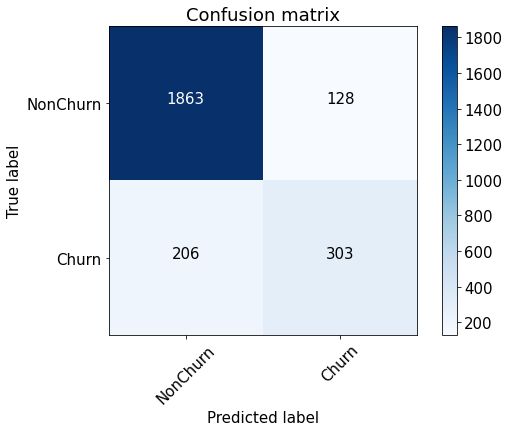

In [28]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_2, preds2 > thresholds2[ix2])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [29]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.5952848722986247, 0.06428930185836264, 0.9357106981416373)

False Positive Rate составил 0.064 - достаточно низкий.
 
Это означает, что 6.4 процента всех клиентов банка получат метку 1 при том, что они на самом деле действующие клиенты.

#### Посчтитаем расходы:

- 1 доллар на удержание одного пользователя, 
- 2 доллара - средняя ожидаемая прибыль с каждого TP (true positive)


посчитать выручку и траты

Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?

In [30]:
attraction = 1 # удержание
retention = 2 # TP

In [31]:
profit = (TN + FN) * retention
spending = (TP + FP) * attraction

print('прибыль с клиентов, которые остались: ', profit)
print('расходы, полученные при удержании: ', spending)

прибыль с клиентов, которые остались:  4138
расходы, полученные при удержании:  431


churn rate = (количество пользователей из набора данных, ушедших в отток)/(общее количество пользователей из набора данных)*100

In [32]:
churn_rate = ((TP + FP) / np.sum(cnf_matrix)) * 100
churn_rate

17.24

17.24% всех полльзователей ушли в отток

# 4. Подбор гиперпараметров лучшей модели<a id='selection'>

* [обратно к меню](#menu)

In [33]:
params={'classifier__max_features':[0.6, 0.7, 0.8],
        'classifier__min_samples_leaf':[14, 16, 18, 20],
        'classifier__max_depth':[None]
        }

In [34]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train_4, y_train_4)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.7,
 'classifier__min_samples_leaf': 18}

In [36]:
pipeline4 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_features=0.7, min_samples_leaf=18, max_depth=None, random_state = 42)),
])

Обучим модель

In [37]:
#обучим наш пайплайн
pipeline4.fit(X_train_4, y_train_4)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [38]:
#наши прогнозы для тестовой выборки
preds4 = pipeline4.predict_proba(X_test_4)[:, 1]

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [39]:
precision4, recall4, thresholds4 = precision_recall_curve(y_test_4, preds4)

fscore4 = (2 * precision4 * recall4) / (precision4 + recall4)
# locate the index of the largest f score
ix4 = np.argmax(fscore4)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds4[ix4], 
                                                                        fscore4[ix4],
                                                                        precision4[ix4],
                                                                        recall4[ix4]))

l4 = []
l4.append('GBClassifier_best')
l4.append(format(thresholds4[ix4], '.3f')), l4.append(format(fscore4[ix4], '.3f')),  
l4.append(format(precision4[ix4], '.3f')), l4.append(format(recall4[ix4], '.3f'))

Best Threshold=0.172018, F-Score=0.623, Precision=0.562, Recall=0.699


(None, None)

# 5. Оценка экономической эффективности лучшей модели<a id='rating_2'>

* [обратно к меню](#menu)

Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1713  278]
 [ 154  355]]


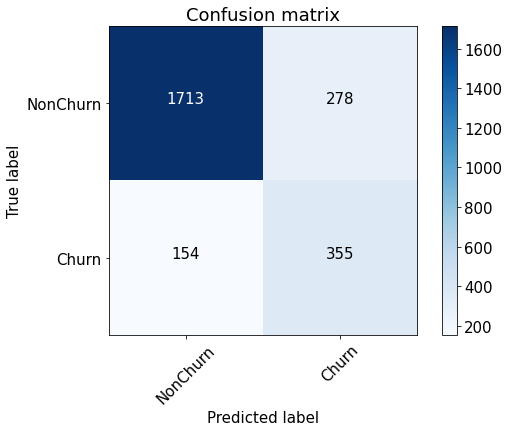

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_4, preds4 > thresholds4[ix4])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [41]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.6974459724950884, 0.13962832747363135, 0.8603716725263687)

False Positive Rate составил 0.139 - достаточно низкий.
 
Это означает, что 13.9 процента всех клиентов банка получат метку 1 при том, что они на самом деле действующие клиенты.

#### Посчтитаем расходы:

- 1 доллар на удержание одного пользователя, 
- 2 доллара - средняя ожидаемая прибыль с каждого TP (true positive)


посчитать выручку и траты

Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?

In [42]:
attraction = 1 # удержание
retention = 2 # TP

In [43]:
profit2 = (TN + FN) * retention
spending2 = (TP + FP) * attraction

print('прибыль с клиентов, которые остались: ', profit2)
print('расходы, полученные при удержании: ', spending2)

прибыль с клиентов, которые остались:  3734
расходы, полученные при удержании:  633


конверсия оттока churn rate = (количество пользователей из набора данных, ушедших в отток)/(общее количество пользователей из набора данных)*100

In [44]:
churn_rate2 = ((TP + FP) / np.sum(cnf_matrix)) * 100
churn_rate2

25.319999999999997

In [45]:
profit2, profit,   spending2, spending

(3734, 4138, 633, 431)